In [ ]:
!pip install -U evaluate
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers

In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
# import evaluate

import csv
from collections import defaultdict

In [6]:
OUTPUT_DIR = 'output'
VAL_RATIO = 0.3
DATA_COLUMNS = ['title', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'label', 'context_score', 'trigger_words']
LABEL_COLUMN = 'category'
LABEL_LIST = []
DATASET_DIR = 'data/test/output_with_category.csv'

## Load Dataset

In [7]:
def load_dataset(file_location):
    df = pd.read_csv(file_location)
    return df

In [9]:
label_list = list(range(0, len(LABEL_LIST)))
data_df = load_dataset(DATASET_DIR)
LABEL_LIST = data_df['category'].unique()
train_data, test_data, train_labels, test_labels = train_test_split(data_df, data_df[LABEL_COLUMN], test_size=VAL_RATIO, random_state=42)

In [10]:
train_data.columns

Index(['title', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos',
       'tag', 'dep', 'label', 'context_score', 'trigger_words', 'category'],
      dtype='object')

In [ ]:
data_df.head()

,title,word_count,character_count,bigrams,lemma,pos,tag,dep,label,context_score,trigger_words,category
0,2006 Pangandaran earthquake and tsunami,5,39,"[('2006', 'Pangandaran'), ('Pangandaran', 'ear...","['2006', 'Pangandaran', 'earthquake', 'and', '...","['NUM', 'PROPN', 'NOUN', 'CCONJ', 'NOUN']","['CD', 'NNP', 'NN', 'CC', 'NN']","['nummod', 'compound', 'ROOT', 'cc', 'conj']","['DATE', '', '', '', '']","{'pangandaran': 0.04385272437177429, 'earthqua...","['pangandaran', 'earthquake', 'tsunami']",environment
1,Battle of Santa Clara (1927),5,28,"[('Battle', 'of'), ('of', 'Santa'), ('Santa', ...","['battle', 'of', 'Santa', 'Clara', '1927']","['NOUN', 'ADP', 'PROPN', 'PROPN', 'NUM']","['NN', 'IN', 'NNP', 'NNP', 'CD']","['ROOT', 'prep', 'compound', 'pobj', 'appos']","['', '', 'GPE', 'GPE', 'DATE']","{'battle': 1.0, 'santa_clara': 0.0}","['battle', 'santa_clara']",politics
2,Siege of Pondicherry (1793),4,27,"[('Siege', 'of'), ('of', 'Pondicherry'), ('Pon...","['siege', 'of', 'Pondicherry', '1793']","['NOUN', 'ADP', 'PROPN', 'NUM']","['NN', 'IN', 'NNP', 'CD']","['ROOT', 'prep', 'pobj', 'appos']","['', '', '', 'DATE']","{'siege': 1.0, 'pondicherry': 0.02664499418035...","['siege', 'pondicherry']",crime
3,Battle of Leuthen,3,17,"[('Battle', 'of'), ('of', 'Leuthen')]","['battle', 'of', 'Leuthen']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['', '', '']","{'battle': 1.0, 'leuthen': 0.012009661111137613}","['battle', 'leuthen']",politics
4,Glasgow St Enoch rail accident,5,30,"[('Glasgow', 'St'), ('St', 'Enoch'), ('Enoch',...","['Glasgow', 'St', 'Enoch', 'rail', 'accident']","['PROPN', 'PROPN', 'PROPN', 'NOUN', 'NOUN']","['NNP', 'NNP', 'NNP', 'NN', 'NN']","['compound', 'compound', 'compound', 'compound...","['GPE', 'GPE', 'GPE', '', '']","{'glasgow_st_enoch': 0.0, 'rail': 1.0, 'accide...","['glasgow_st_enoch', 'rail', 'accident']",crime


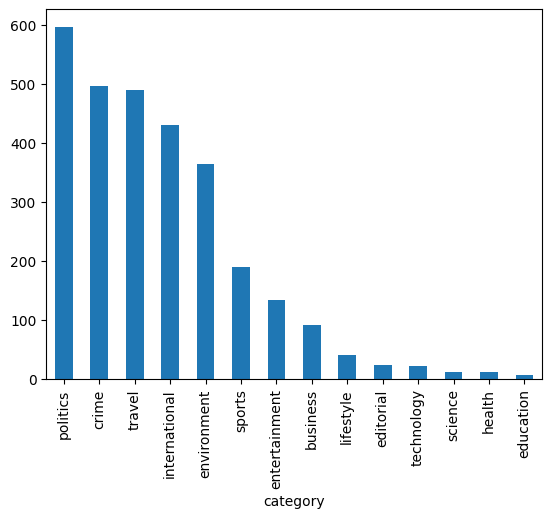

In [ ]:
# @title category

from matplotlib import pyplot as plt

def plot_category_distribution(data_df):
    category_counts = data_df['category'].value_counts()
    category_counts.plot(kind='bar')
    plt.show()

plot_category_distribution(data_df)

In [ ]:
print('Length of labels:', len(label_list))
print('Shape of the training data: ', train_data.shape)
print('Shape of the test data: ', test_data.shape)

Length of labels: 14
Shape of the training data:  (2036, 12)
Shape of the test data:  (873, 12)


In [ ]:
model_checkpoint = "google/bert_uncased_L-2_H-128_A-2"
max_length = 128

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
from datasets import Dataset

def preprocess_function(input_data):
    # Extract titles from input_data
    titles = input_data['title'].tolist()

    # Tokenize each title separately
    tokenized_inputs = tokenizer(titles, padding=True, truncation=True, max_length=max_length)

    # Create a list of dictionaries containing the tokenized inputs and labels
    tokenized_data = []
    for i in range(len(titles)):
        example = {
            'text': titles[i],
            'label': input_data[LABEL_COLUMN].iloc[i],  # Assuming the label column name is LABEL_COLUMN
            'input_ids': tokenized_inputs['input_ids'][i],
            'token_type_ids': tokenized_inputs['token_type_ids'][i],
            'attention_mask': tokenized_inputs['attention_mask'][i]
        }
        tokenized_data.append(example)

    return tokenized_data

In [ ]:
encoded_train = preprocess_function(train_data)
encoded_test = preprocess_function(test_data)
encoded_train

[{'text': 'Bloody Sunday (1920)',
  'label': 'crime',
  'input_ids': [101,
   6703,
   4465,
   1006,
   4444,
   1007,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'token_type_ids': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'attention_mask': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]},
 {'text': 'Iran–Contra affair',
  'label': 'international',
  'input_ids': [101,
   4238,
   1516,
   24528,
   6771,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'token_type_ids': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'attention_mask': [1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]},
 {'text': 'Bad Blood (20

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model.resize_token_embeddings(len(tokenizer)) # need to resize due to new tokens added

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30522, 128, padding_idx=0)

In [ ]:
metric_name = 'f1'
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"./snapshots/{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
    fp16=True
)

In [ ]:
metric = evaluate.load(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_log = trainer.train()

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`label` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device="cuda:0")
results = classifier(test_data['title'].tolist(), max_length=max_length, padding="max_length", truncation=True)
dfResults = pd.DataFrame.from_dict(results)
dfResults['label'] = dfResults['label'].str.replace('LABEL_','')
f1 = metric.compute(predictions=dfResults['label'].tolist(), references=test_data[LABEL_COLUMN].tolist(), average='micro')
print(f1)

In [ ]:
trainer.save_model("./models/FinetunedModel") # for saving your model